In [81]:
!pip install pandas matplotlib seaborn altair pingouin lxml html5lib beautifulsoup4

In [82]:
import pathlib as plib
from tabulate import tabulate

import pandas as pd
import numpy as np
import string

import scipy.stats as st
from scipy import signal
from scipy.optimize import curve_fit

import pingouin as pg # for post-host pairwise test

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('tab10')

In [83]:
cwd = plib.Path.cwd()

if cwd.name == 'favorite_letters':
    print("Path is project root")
else:
    print('Current Working Directory is:', cwd)
    print("Recomend navigating to the project root in terminal and opening your chosen idea via the command 'code .'")
    raise NameError('Please correct current working directory to the project root')

data_path = plib.PurePath('letter_popularity_poll-Responses-sorted_data.csv')

Path is project root


In [84]:
data = pd.read_csv(data_path)
data.tail(3)

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier
1173,Ṹ,7800,Latin Extended Additional,Ṹ (LATIN CAPITAL LETTER U WITH TILDE AND ACUTE),19,22,12,9,2,2,1,1.44776,1.39570,67,D
1174,ấ,7845,Latin Extended Additional,ấ (LATIN SMALL LETTER A WITH CIRCUMFLEX AND AC...,22,22,12,8,1,1,3,1.40580,1.50801,69,D
1175,Ễ,7876,Latin Extended Additional,Ễ (LATIN CAPITAL LETTER E WITH CIRCUMFLEX AND ...,24,22,15,6,3,1,2,1.35616,1.42760,73,D


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   letter         1176 non-null   object 
 1   codepoint      1176 non-null   int64  
 2   block          1176 non-null   object 
 3   name           1176 non-null   object 
 4   0              1176 non-null   int64  
 5   1              1176 non-null   int64  
 6   2              1176 non-null   int64  
 7   3              1176 non-null   int64  
 8   4              1176 non-null   int64  
 9   5              1176 non-null   int64  
 10  6              1176 non-null   int64  
 11  average        1176 non-null   float64
 12  standard dev.  1176 non-null   float64
 13  ratings        1176 non-null   int64  
 14  tier           1176 non-null   object 
dtypes: float64(2), int64(9), object(4)
memory usage: 137.9+ KB


# TODO: describe describe

In [86]:
describe_df = data.describe()
describe_df

,codepoint,0,1,2,3,4,5,6,average,standard dev.,ratings
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,15330.961735,7.880952,12.798469,13.196429,14.121599,11.479592,7.392007,7.800170,2.778416,1.658098,74.669218
std,25235.732055,4.697608,5.967232,4.712466,4.904155,5.966824,5.512098,6.682084,0.711294,0.173744,9.312829
min,65.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.356160,1.220240,42.000000
25%,440.750000,4.000000,8.000000,10.000000,11.000000,7.000000,3.000000,3.000000,2.219498,1.533622,69.750000
50%,7552.500000,7.000000,13.000000,13.000000,13.000000,11.000000,6.000000,6.000000,2.684210,1.647065,75.000000
75%,11371.250000,10.250000,17.000000,16.000000,17.000000,16.000000,11.000000,10.000000,3.329030,1.765290,80.000000
max,122666.000000,29.000000,29.000000,27.000000,37.000000,30.000000,28.000000,53.000000,4.724140,2.364680,107.000000


In [87]:
plot_describe_df = describe_df.transpose().loc['0':'6'].reset_index()
plot_describe_df = plot_describe_df.rename(columns={'index':'rating'})
plot_describe_df['lower_bound']  = plot_describe_df['mean'] - plot_describe_df['std']
plot_describe_df['upper_bound']  = plot_describe_df['mean'] + plot_describe_df['std']
plot_describe_df

,rating,count,mean,std,min,25%,50%,75%,max,lower_bound,upper_bound
0,0,1176.0,7.880952,4.697608,0.0,4.0,7.0,10.25,29.0,3.183345,12.578560
1,1,1176.0,12.798469,5.967232,0.0,8.0,13.0,17.00,29.0,6.831237,18.765702
2,2,1176.0,13.196429,4.712466,1.0,10.0,13.0,16.00,27.0,8.483962,17.908895
3,3,1176.0,14.121599,4.904155,3.0,11.0,13.0,17.00,37.0,9.217444,19.025753
4,4,1176.0,11.479592,5.966824,0.0,7.0,11.0,16.00,30.0,5.512768,17.446416
5,5,1176.0,7.392007,5.512098,0.0,3.0,6.0,11.00,28.0,1.879909,12.904105
6,6,1176.0,7.800170,6.682084,1.0,3.0,6.0,10.00,53.0,1.118086,14.482254


# Distributions of average ratings and assigned Tier


## Skew and Kurtosis
Skew of averages is 0.376, fairly low. This distribution of averages is not considerably skewed, as can be seen in the plot, the median and mode are close together. Difference of 0.094, ~ 3% on observed scale.

Negative kurtosis (-1) indicates our distributionof averages is considerably flatter than a normal distribution. This is not concerning as a distributions of averages is expected to be flatter than normal.

In [88]:
tier_full = ['S+', 'S', 'S-', 'A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']
data['tier'].unique()

array(['A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D'],
      dtype=object)

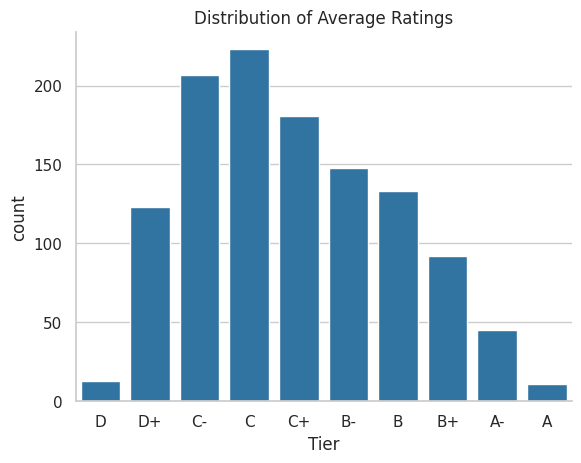

In [89]:
fig, ax = plt.subplots()
sns.countplot(data=data, x='tier')

ax.xaxis.set_inverted(True)
ax.set_xlabel("Tier")
ax.set_title("Distribution of Average Ratings")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/tier_dist_freq_plot")

In [90]:
mean = round(data['average'].mean(), 3)
median = round(data['average'].median(), 3)

print('mean', mean, '| median', median)

print('mode')
data['average'].\
    value_counts().\
        sort_values(ascending=False).\
            rename('freq').\
                head(3)\
                    .reset_index()

mean 2.778 | median 2.684
mode


,average,freq
0,3.50000,6
1,2.00000,6
2,1.85714,4


16 potential tiers, only 10 applicable to data


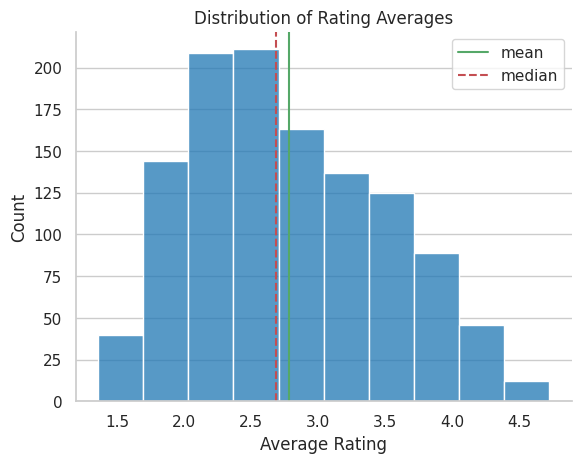

In [91]:
print(f'{len(tier_full)} potential tiers, only 10 applicable to data')

fig, ax = plt.subplots()
sns.histplot(data=data, x='average', bins=10)

# add median line
ax.axvline(mean, color='g', linestyle='-', label='mean')
# add mean line
ax.axvline(median, color='r', linestyle='--',label='median')
# add legend
ax.legend()

ax.set_xlabel("Average Rating")
ax.set_title("Distribution of Rating Averages")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/rating_dist_histogram")

In [92]:
print('Diff of Median and mean:', round(median - mean, 3))

Diff of Median and mean: -0.094


In [93]:
skew_avgs = round(st.skew(data['average']), 3)
kurtosis_avgs = round(st.kurtosis(data['average']))
print('skew:', skew_avgs, '| kurtosis', kurtosis_avgs)

skew: 0.376 | kurtosis -1


# Distributions of each rating value

## Skew and Kurtosis per rating value

There  higher skew in the number of ratings on the extreme values. Dead center, high, and low.

All skewness present is towards high frequency values, indidcating there were no unsually small amount of measurements.

This skew can also be seen in the kurtosis of these values, where 6 has a very long positive tails.

Both features are obvious in the violin plots.

## Favorite and default bias

Additionally, a strong 'favorites' bias was found, where popular characters garnered the most votes, though a perfectly middle 'default' vote also saw a higher frequency.

Violin plot is misleading as there are no values below 0 in the dataset.

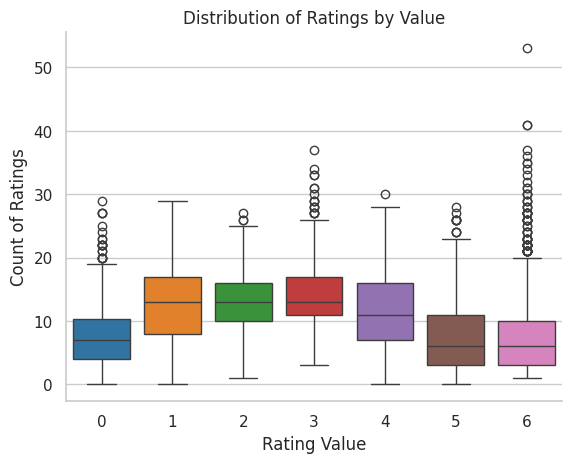

In [94]:
# Pull out a specific subset of columns
used_columns = ['0', '1', '2', '3', '4', '5', '6']
df = data.loc[:, used_columns]

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=df)

# Finalize the figure
ax.set_xlabel("Rating Value")
ax.set_ylabel("Count of Ratings")
ax.set_title("Distribution of Ratings by Value")
sns.despine()
fig.savefig("images/ratings_distributions_box")

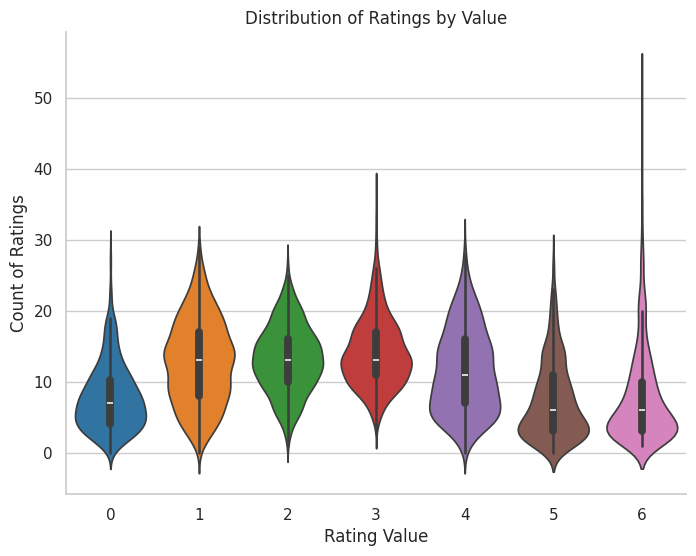

In [95]:
# Pull out a specific subset of columns
used_columns = ['0', '1', '2', '3', '4', '5', '6']
df = data.loc[:, used_columns]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,6))

# Draw a violinplot with a narrower bandwidth than the default
parts = sns.violinplot(data=df)

# Finalize the figure
ax.set_xlabel("Rating Value")
ax.set_ylabel("Count of Ratings")
ax.set_title("Distribution of Ratings by Value")
sns.despine()
fig.savefig("images/ratings_distributions_violin")

In [96]:

cutoff = 35
for rating in used_columns:
    col = data[rating]
    if not data[col > cutoff].empty:
        print('rating', rating, '\n', tabulate(data[col > cutoff]))
    else:
        print(f'No values > {cutoff} in rating {rating}')

No values > 35 in rating 0
No values > 35 in rating 1
No values > 35 in rating 2
rating 3 
 ---  -  --  -----------  --------------------------  -  -  -  --  --  --  -  -------  -------  --  -
174  H  72  Basic Latin  H (LATIN CAPITAL LETTER H)  3  1  6  37  13  12  9  3.58025  1.37717  81  B
---  -  --  -----------  --------------------------  -  -  -  --  --  --  -  -------  -------  --  -
No values > 35 in rating 4
No values > 35 in rating 5
rating 6 
 --  -  ----  -------------------  ---------------------------------------  -  -  -  --  --  --  --  -------  -------  ---  --
 1  ɤ   612  IPA Extensions       ɤ (LATIN SMALL LETTER RAMS HORN)         3  4  4   5  19  26  41  4.69608  1.55932  102  A
 2  ᴥ  7461  Phonetic Extensions  ᴥ (LATIN LETTER AIN)                     4  8  3   5  14  13  53  4.68     1.8306   100  A
 3  ö   246  Latin-1 Supplement   ö (LATIN SMALL LETTER O WITH DIAERESIS)  2  4  3   7  18  11  37  4.63415  1.62171   82  A
 4  Þ   222  Latin-1 Supplement   Þ (LA

In [97]:
table = []
for rating in used_columns:
    col = data[rating]
    skew_avgs = round(st.skew(col), 3)
    kurtosis_avgs = round(st.kurtosis(col), 3)
    table.append((rating, skew_avgs, kurtosis_avgs))
pd.DataFrame(table, columns=('rating','skew','kurtosis'))

,rating,skew,kurtosis
0,0,0.966,0.993
1,1,0.173,-0.627
2,2,0.068,-0.411
3,3,0.735,0.850
4,4,0.416,-0.602
5,5,0.996,0.495
6,6,1.837,4.460


# Examination of rating count trends

A bias in this survery is seem where higher rating, more attractive characters gather significantly more ratings than other characters. TODO: ML char of groupings?

In [98]:
# Feature engineer total vote count.
used_columns = ['0', '1', '2', '3', '4', '5', '6', 'average']
df_ct_sum = data.loc[:, used_columns]
df_ct_sum['count_sum'] = df.sum(axis=1)
# Reduce df size for easier working
df = df_ct_sum[['average', 'count_sum']]
#describe the x-axis for binning
df['count_sum'].describe()


count    1176.000000
mean       74.669218
std         9.312829
min        42.000000
25%        69.750000
50%        75.000000
75%        80.000000
max       107.000000
Name: count_sum, dtype: float64

In [99]:
df['binned'] = pd.cut(df['count_sum'], bins= range(40,120,10))
df

/tmp/ipykernel_19213/3368822305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binned'] = pd.cut(df['count_sum'], bins= range(40,120,10))


,average,count_sum,binned
0,4.72414,87,"(80, 90]"
1,4.69608,102,"(100, 110]"
2,4.68000,100,"(90, 100]"
3,4.63415,82,"(80, 90]"
4,4.55882,102,"(100, 110]"
...,...,...,...
1171,1.46269,67,"(60, 70]"
1172,1.45588,68,"(60, 70]"
1173,1.44776,67,"(60, 70]"
1174,1.40580,69,"(60, 70]"


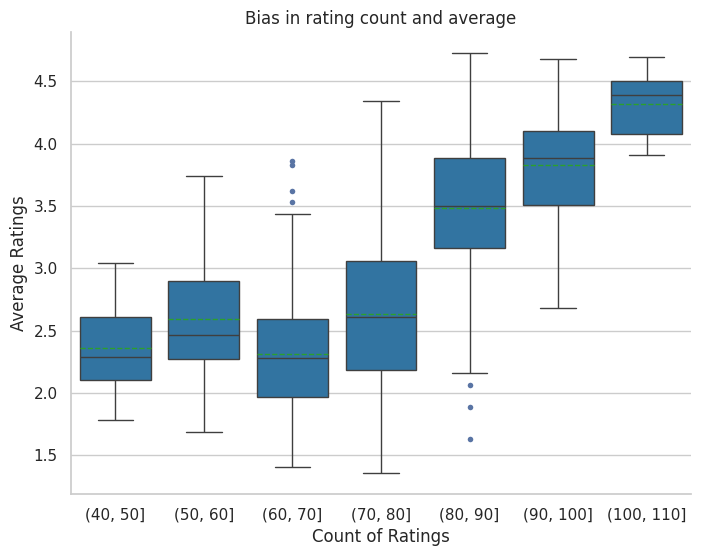

In [100]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=df, x='binned', y='average',
            showmeans=True, meanline=True,
            flierprops={'markerfacecolor':'#5974A4', 
                        'markersize':4,
                        'markeredgecolor':'none'})

# Finalize the figure
ax.set_xlabel("Count of Ratings")
ax.set_ylabel("Average Ratings")
ax.set_title("Bias in rating count and average")
sns.despine()
fig.savefig("images/rating_count_vs_avg_ratings_box")

In [101]:
# Feature engineer total vote count.
used_columns = ['average', 'standard dev.']
var_avg_df = data.loc[:, used_columns]
# build a filtered dataset to show trend clearly
var_avg_df['savgol_filter_stdev'] = signal.savgol_filter(data['standard dev.'], 175, 1)
var_avg_df['double_savgol_stdev'] = signal.savgol_filter(var_avg_df['savgol_filter_stdev'], 175, 3)


In [102]:
def func(x, a, b, c, d):
    # a: amplitude of the peak
    # b: x offset of the peak
    # c: steepness of the peak
    # d: y offset of the peak
    # Approximate the curve with a normal distribution
    return a * np.exp( -(x-b) **2 / (2 * c **2)) + d
xdata = var_avg_df['average']
ydata = var_avg_df['standard dev.']
# Guess provided from double savgol filter 
initial_guess = [0.2, 3.0, 1, 1.5]
popt, pcov = curve_fit(func, xdata, ydata, p0=initial_guess)
df_model_avgstdev = pd.DataFrame({'modelx':xdata, 'calcy':func(xdata, *popt)})
print('condition number of a matrix:', np.linalg.cond(pcov))
print('matrix diagonal:', np.diag(pcov))
print('coefficents determined:', 'a =', round(popt[0],3), '| b =', round(popt[1],3), '| c =', round(popt[2],3), '| d =', round(popt[3],3))


condition number of a matrix: 630.1692519806115
matrix diagonal: [0.00086382 0.00084007 0.00738178 0.00100469]
coefficents determined: a = 0.277 | b = 3.158 | c = 0.722 | d = 1.485


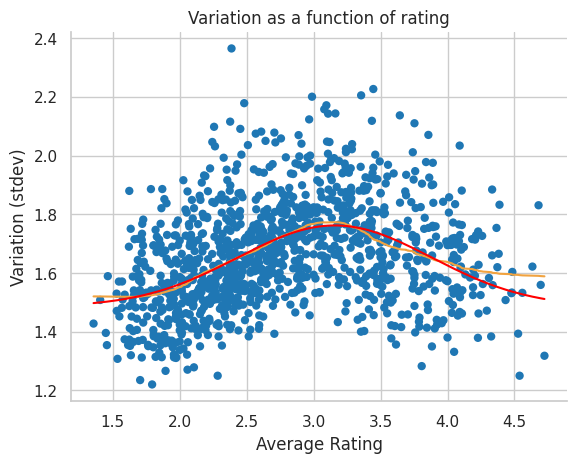

In [103]:
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=var_avg_df,  y='standard dev.', x='average',
                edgecolor="none")
# Draw the savgol filtered data to show a trend
sns.lineplot(data=var_avg_df,  y='double_savgol_stdev', x='average', color= '#f1a340')
sns.lineplot(data=df_model_avgstdev, y='calcy', x='modelx', color= 'red')

# Finalize the ax1
ax.set_xlabel("Average Rating")
ax.set_ylabel("Variation (stdev)")
ax.set_title("Variation as a function of rating")
sns.despine()
fig.savefig("images/avg_stdev_scatter")


# Separate out letters from special characters
In order to examine any difference in rating behavior split common english characters from special ones.

This will be used to test the hypothesis that common characters will have less extreme ratings than special characters.

In [104]:
letters_df = data[data['letter'].str.contains('[a-zA-Z]')]
letters_df['alphabetic'] = True
special_char_df = data[~data['letter'].str.contains('[a-zA-Z]')]
special_char_df['alphabetic'] = False

/tmp/ipykernel_19213/645393701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  letters_df['alphabetic'] = True
/tmp/ipykernel_19213/645393701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  special_char_df['alphabetic'] = False


In [105]:
letters_df.shape

(52, 16)

In [106]:
special_char_df.shape

(1124, 16)

In [107]:
# empty dataframe confirming punctionation is not part of this dataset
data[data['letter'].str.contains(f'[{string.punctuation}]')]

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier


# Alphabetic characters score higher than average with low variance

In [108]:
var_avg_labd_df = data.copy()
var_avg_labd_df['alphabetic'] = data['letter'].str.contains('[a-zA-Z]')

# Feature engineer total vote count.
used_columns = ['average', 'standard dev.', 'alphabetic']
df = var_avg_labd_df.loc[:, used_columns]
# build a filtered dataset to show trend clearly
var_avg_labd_df['savgol_filter_stdev'] = signal.savgol_filter(df['standard dev.'], 175, 1)
var_avg_labd_df['double_savgol_stdev'] = signal.savgol_filter(var_avg_labd_df['savgol_filter_stdev'], 175, 3)


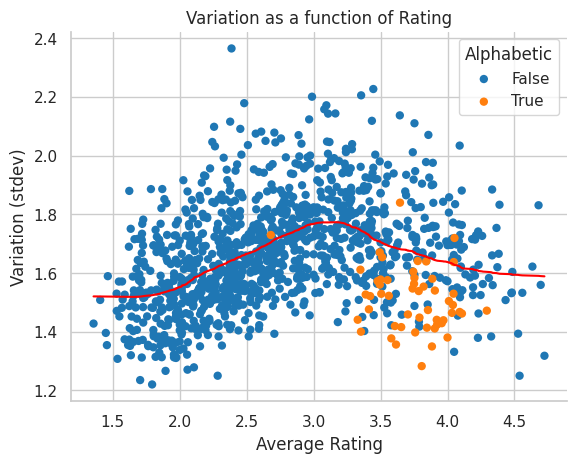

In [109]:
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=special_char_df,  y='standard dev.', x='average', label='False',
                edgecolor="none")
sns.scatterplot(data=letters_df,  y='standard dev.', x='average', label='True',
                edgecolor="none")
# Draw the savgol filtered data to show a trend
sns.lineplot(data=var_avg_labd_df,  y='double_savgol_stdev', x='average', color= 'red')

# Finalize the ax1
ax.set_xlabel("Average Rating")
ax.set_ylabel("Variation (stdev)")
ax.set_title("Variation as a function of Rating")
ax.legend(title='Alphabetic')
sns.despine()
fig.savefig("images/avg_stdev_scatter_alphabetic")

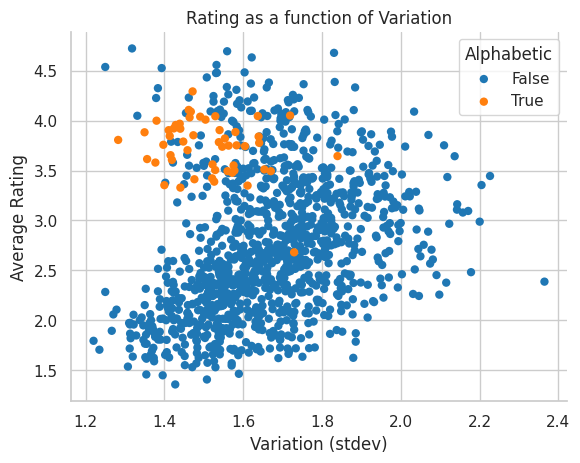

In [110]:
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=special_char_df,  x='standard dev.', y='average', label='False',
                edgecolor="none")
sns.scatterplot(data=letters_df,  x='standard dev.', y='average', label='True',
                edgecolor="none")

# Finalize the ax1
ax.set_ylabel("Average Rating")
ax.set_xlabel("Variation (stdev)")
ax.set_title("Rating as a function of Variation")
ax.legend(title='Alphabetic')
sns.despine()
fig.savefig("images/avg_stdev_scatter_alphabetic_xyswap")

In [111]:
print('special char avg mean:',round(special_char_df['average'].mean(),3))
print('eng letters avg mean:',round(letters_df['average'].mean(),3))

special char avg mean: 2.734
eng letters avg mean: 3.734


In [112]:
print('special char stdev mean:',round(special_char_df['standard dev.'].mean(),3))
print('eng letters stdev mean:',round(letters_df['standard dev.'].mean(),3))

special char stdev mean: 1.665
eng letters stdev mean: 1.513


# Outlier examination
Lowercase l is an outlier with much lower average than other english letters.

Capital O is an outlier with higher variation than other english letters.

Neither of these are outliers with respect to the larger set of characters surveyed, and there are no outliers in average in the larger set of characters surveyed.

Anything above approximately a 2.11 in standard deviation is an outlier according to the 1.5*IQR+Q3 metric used. Howeverm these values wil not be removed as this could be attributed to the shape of the average-stdev plot, where more averagely scoring characters have higher variance. #TODO: check with stats.  


In [113]:
def get_outliers(df, column):
    # get 1st and 3rd quatile values and the range between them
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # set the value limits
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    # get the outlier rows from the df for this column
    upper_outliers = df[df[column] > upper_lim]
    lower_outliers = df[df[column] < lower_lim]
    return upper_outliers, lower_outliers


In [114]:
pd.concat(get_outliers(letters_df, 'average'))

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,alphabetic
589,l,108,Basic Latin,l (LATIN SMALL LETTER L),12,15,19,19,16,10,6,2.68041,1.72932,97,C+,True


In [115]:
pd.concat(get_outliers(letters_df, 'standard dev.'))

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,alphabetic
158,O,79,Basic Latin,O (LATIN CAPITAL LETTER O),10,3,5,25,19,11,20,3.64516,1.83945,93,B,True


In [116]:
pd.concat(get_outliers(data, 'standard dev.')).sort_values('standard dev.').shape

(13, 15)

In [117]:
pd.concat(get_outliers(data, 'average'))

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier


In [118]:
data['total_votes'] = data['0'] + data['1'] + data['2'] + data['3'] + data['4'] + data['5'] + data['6']
pd.concat(get_outliers(data, 'total_votes')).sort_values('total_votes').head(7)

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,total_votes
968,𝼩,122665,Latin Extended-G,𝼩 (LATIN SMALL LETTER S WITH MID-HEIGHT LEFT H...,11,5,10,9,3,1,3,2.07143,1.75850,42,C-,42
900,Ꟍ,42956,Latin Extended-D,Ꟍ (LATIN CAPITAL LETTER S WITH DIAGONAL STROKE),12,7,6,9,4,2,4,2.18182,1.93226,44,C-,44
768,𝼦,122662,Latin Extended-G,𝼦 (LATIN SMALL LETTER L WITH MID-HEIGHT LEFT H...,11,5,6,13,3,3,4,2.37778,1.89843,45,C,45
407,𝼞,122654,Latin Extended-G,𝼞 (LATIN SMALL LETTER S WITH CURL),5,4,7,13,8,3,6,3.04348,1.77584,46,B-,46
606,Ƛ,42972,Latin Extended-D,Ƛ (LATIN CAPITAL LETTER LAMBDA WITH STROKE),7,6,8,12,4,6,3,2.65217,1.79155,46,C+,46
627,𝼗,122647,Latin Extended-G,𝼗 (LATIN SMALL LETTER TESH DIGRAPH WITH PALATA...,9,10,4,7,4,7,5,2.60870,2.08143,46,C,46
943,ꟊ,42954,Latin Extended-D,ꟊ (LATIN SMALL LETTER S WITH SHORT STROKE OVER...,9,10,10,9,4,4,1,2.10638,1.63167,47,C-,47


In [119]:
data.loc[768, 'name']

'𝼦 (LATIN SMALL LETTER L WITH MID-HEIGHT LEFT HOOK)'

In [120]:
data.loc[968, 'name']

'𝼩 (LATIN SMALL LETTER S WITH MID-HEIGHT LEFT HOOK)'

In [121]:
mean = round(data['total_votes'].mean(), 3)
median = round(data['total_votes'].median(), 3)

print('mean', mean, '| median', median)

print('mode')
data['total_votes'].\
    value_counts().\
        sort_values(ascending=False).\
            rename('freq').\
                head(3)\
                    .reset_index()

mean 74.669 | median 75.0
mode


,total_votes,freq
0,76,70
1,75,66
2,71,64


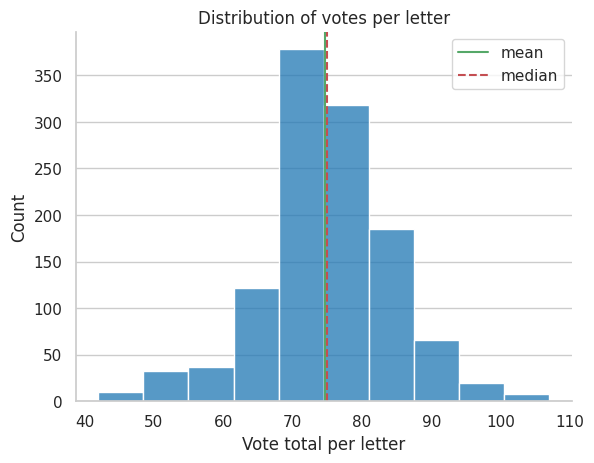

In [122]:
fig, ax = plt.subplots()
sns.histplot(data=data, x='total_votes', bins=10)

# add median line
ax.axvline(mean, color='g', linestyle='-', label='mean')
# add mean line
ax.axvline(median, color='r', linestyle='--',label='median')
# add legend
ax.legend()

ax.set_xlabel("Vote total per letter")
ax.set_title("Distribution of votes per letter")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/votes_per_letter_hist")

In [123]:
skew_avgs = round(st.skew(data['total_votes']), 3)
kurtosis_avgs = round(st.kurtosis(data['total_votes']))
print('skew:', skew_avgs, '| kurtosis', kurtosis_avgs)

skew: -0.138 | kurtosis 1


# Basic statistics to support intuitive interpretations of visualizations

* T-test, Are english letters avg ratings staistically different from other characters?
  * Very different, as observed. 
  * P ~ e-36, T = -22. They are different.
* T-test standard deviation. Are the high variance values statistically different from the tails?
  * Intuitively I can say the middle has higher variation than the sides, is that true
  * P ~ e-40, T = 14. They are different. 

In [124]:
results = pg.ttest(data['average'], letters_df['average'])
print("\nPingouin Paired T-Test Results For english letters vs all characters:")
print(results)


Pingouin Paired T-Test Results For english letters vs all characters:
                T        dof alternative         p-val           CI95%  \
T-test -21.920676  84.884222   two-sided  1.043236e-36  [-1.04, -0.87]   

         cohen-d       BF10  power  
T-test  1.368057  1.023e+86    1.0  


In [125]:
dub_savgol = var_avg_labd_df['double_savgol_stdev']
dub_savgol.describe()

count    1176.000000
mean        1.657336
std         0.077857
min         1.518402
25%         1.601723
50%         1.659838
75%         1.724137
max         1.772781
Name: double_savgol_stdev, dtype: float64

In [126]:
third_around_high = dub_savgol.nlargest(dub_savgol.shape[0] // 3)
highest_third_savgol = var_avg_labd_df[var_avg_labd_df['double_savgol_stdev'].isin(third_around_high)]
outside_high_savgol = var_avg_labd_df[~var_avg_labd_df['double_savgol_stdev'].isin(third_around_high)]

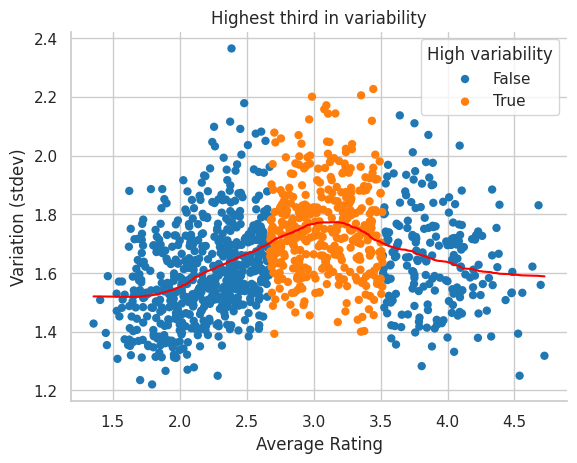

In [127]:
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=outside_high_savgol,  y='standard dev.', x='average', label='False',
                edgecolor="none")
sns.scatterplot(data=highest_third_savgol,  y='standard dev.', x='average', label='True',
                edgecolor="none")
# Draw the savgol filtered data to show a trend
sns.lineplot(data=var_avg_labd_df,  y='double_savgol_stdev', x='average', color= 'red')

# Finalize the ax1
ax.set_xlabel("Average Rating")
ax.set_ylabel("Variation (stdev)")
ax.set_title("Highest third in variability")
ax.legend(title='High variability')
sns.despine()
fig.savefig("images/savgol_high")

In [128]:
results = pg.ttest(highest_third_savgol['standard dev.'], outside_high_savgol['standard dev.'])
print("\nPingouin Paired T-Test Results For higher vs lower variability:")
print(results)


Pingouin Paired T-Test Results For higher vs lower variability:
                T         dof alternative         p-val         CI95%  \
T-test  13.978515  842.679569   two-sided  4.361761e-40  [0.12, 0.15]   

         cohen-d      BF10 power  
T-test  0.840984  5.37e+37   NaN  


# Grab letter frequency table

# Relationship of letter frequency to rating
X is the most popular letter character but 23/26 in letter frequency. This frequency table is for full words however, and this may bias down the frequency of x as it is common as a placeholder, a feature which is not represented in this table.

However, the addition of other uncommon letters such as W and Q in the top five most popular survery letters indicates there is no relationship here. Furthermore, the top 10 has no non-vowel overlap, except S.

Interestingly the bottom 3 most common letters are very popular, however this is not a trend as there is no other overlap in the least common 10 letters and the 10 most popular



In [ ]:
wikipedia_letter_freq = pd.read_html('https://en.wikipedia.org/wiki/Letter_frequency')
# Get the first table from the wikipedia page, indicating letter freq in text and dictionary
# If wikipedia removes the 'needs citation banner thus 1 must be a 0
wikipedia_letter_freq = wikipedia_letter_freq[1]
# flatten multi-level column index
wikipedia_letter_freq.columns = wikipedia_letter_freq.columns.get_level_values(1)
# Drop useless NaN columns
wikipedia_letter_freq = wikipedia_letter_freq.drop(columns=['Texts.1', 'Dictionaries[citation needed].1'])
col_names = ['letter', 'texts_freq', 'dictionaries_freq']
wikipedia_letter_freq.columns = col_names
wikipedia_letter_freq.dtypes

letter               object
texts_freq           object
dictionaries_freq    object
dtype: object

In [135]:
# Convert percent strings to float decimal percentage
for col in col_names[1:]:
    wikipedia_letter_freq[col] = wikipedia_letter_freq[col].str.rstrip('%').astype('float') /100

In [136]:
# order the letters by decreasing freq
ordered_letter_freq = wikipedia_letter_freq.sort_values('texts_freq', ascending=False)
# generate a second column of lowercase letters for joining
ordered_letter_freq['lowercase'] = ordered_letter_freq['letter'].str.lower()
# reorder so letter columns are adjacent
ordered_letter_freq = ordered_letter_freq.loc[:, ['letter','lowercase','texts_freq','dictionaries_freq']]
ordered_letter_freq = ordered_letter_freq.reset_index()
ordered_letter_freq.head(10)

,index,letter,lowercase,texts_freq,dictionaries_freq
0,4,E,e,0.127,0.110
1,19,T,t,0.091,0.067
2,0,A,a,0.082,0.078
3,14,O,o,0.075,0.061
4,8,I,i,0.070,0.086
5,13,N,n,0.067,0.072
6,18,S,s,0.063,0.087
7,7,H,h,0.061,0.023
8,17,R,r,0.060,0.073
9,3,D,d,0.043,0.038


In [137]:
ordered_letter_freq[ordered_letter_freq['lowercase'].eq('x')]

,index,letter,lowercase,texts_freq,dictionaries_freq
23,23,X,x,0.0015,0.0027


In [138]:
ordered_survery_letters = letters_df.sort_values('average', ascending=False)
ordered_survery_letters.head(11)

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,alphabetic
20,x,120,Basic Latin,x (LATIN SMALL LETTER X),2,4,4,10,30,19,23,4.29348,1.47162,92,A-,True
39,e,101,Basic Latin,e (LATIN SMALL LETTER E),1,3,7,31,14,23,23,4.10784,1.46177,102,A-,True
48,W,87,Basic Latin,W (LATIN CAPITAL LETTER W),2,2,6,23,15,23,17,4.09091,1.46716,88,A-,True
57,X,88,Basic Latin,X (LATIN CAPITAL LETTER X),7,2,3,22,20,17,25,4.05208,1.71906,96,B+,True
60,Q,81,Basic Latin,Q (LATIN CAPITAL LETTER Q),5,2,5,18,15,24,17,4.04651,1.63712,86,B+,True
61,S,83,Basic Latin,S (LATIN CAPITAL LETTER S),2,2,11,16,22,16,20,4.04494,1.52934,89,B+,True
63,A,65,Basic Latin,A (LATIN CAPITAL LETTER A),3,2,7,24,23,20,20,4.04040,1.49092,99,B+,True
67,V,86,Basic Latin,V (LATIN CAPITAL LETTER V),1,3,9,21,21,17,19,4.03297,1.46402,91,B+,True
72,Z,90,Basic Latin,Z (LATIN CAPITAL LETTER Z),2,4,10,17,21,26,16,4.01042,1.50434,96,B+,True
74,i,105,Basic Latin,i (LATIN SMALL LETTER I),1,3,5,24,18,21,13,4.00000,1.38013,85,B+,True


#

# Split by letter

Cannot split by block due to every block containing some broadly familiar (eg. visibly e containing character with some modification) and some unfamiliar letters (eg. greek)

In [139]:
df_weird_letters = pd.DataFrame(columns=data.columns)
letter_types = ['SMALL', 'CAPITAL']
for letter in string.ascii_uppercase:
    for type in letter_types:
        grep_str = '{type} LETTER {let}[\W|\)]'.format(type = type, let = letter)
        df_next = data[data['name'].str.contains(grep_str, regex=True)]
        df_weird_letters = pd.concat([df_weird_letters,df_next])
df_weird_letters


<>:5: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_19213/928434520.py:5: SyntaxWarning: invalid escape sequence '\W'
  grep_str = '{type} LETTER {let}[\W|\)]'.format(type = type, let = letter)
/tmp/ipykernel_19213/928434520.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weird_letters = pd.concat([df_weird_letters,df_next])


,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,total_votes
88,a,97,Basic Latin,a (LATIN SMALL LETTER A),2,7,10,20,26,23,18,3.90566,1.54012,106,B+,106
285,å,229,Latin-1 Supplement,å (LATIN SMALL LETTER A WITH RING ABOVE),4,7,19,17,19,12,11,3.34831,1.64525,89,B-,89
299,ä,228,Latin-1 Supplement,ä (LATIN SMALL LETTER A WITH DIAERESIS),3,12,10,22,21,13,8,3.31461,1.58541,89,B-,89
341,ꬱ,43825,Latin Extended-E,ꬱ (LATIN SMALL LETTER A REVERSED-SCHWA),7,5,17,17,11,9,12,3.21795,1.80654,78,B-,78
398,â,226,Latin-1 Supplement,â (LATIN SMALL LETTER A WITH CIRCUMFLEX),3,15,5,18,18,5,7,3.07042,1.65895,71,B-,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,Ż,379,Latin Extended-A,Ż (LATIN CAPITAL LETTER Z WITH DOT ABOVE),4,19,14,16,6,5,6,2.57143,1.67307,70,C,70
778,Ẑ,7824,Latin Extended Additional,Ẑ (LATIN CAPITAL LETTER Z WITH CIRCUMFLEX),6,17,15,19,5,6,2,2.37143,1.50527,70,C,70
785,Ⱬ,11371,Latin Extended-C,Ⱬ (LATIN CAPITAL LETTER Z WITH DESCENDER),8,15,20,13,13,5,1,2.36000,1.48542,75,C,75
808,Ẕ,7828,Latin Extended Additional,Ẕ (LATIN CAPITAL LETTER Z WITH LINE BELOW),5,21,12,20,7,3,3,2.33803,1.49230,71,C,71


In [140]:
df_unique_chars = data[~data['codepoint'].isin(df_weird_letters['codepoint'])]
df_unique_chars

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier,total_votes
0,ʘ,664,IPA Extensions,ʘ (LATIN LETTER BILABIAL CLICK),1,0,4,12,15,23,32,4.72414,1.31794,87,A,87
1,ɤ,612,IPA Extensions,ɤ (LATIN SMALL LETTER RAMS HORN),3,4,4,5,19,26,41,4.69608,1.55932,102,A,102
2,ᴥ,7461,Phonetic Extensions,ᴥ (LATIN LETTER AIN),4,8,3,5,14,13,53,4.68000,1.83060,100,A,100
4,Þ,222,Latin-1 Supplement,Þ (LATIN CAPITAL LETTER THORN),2,4,4,14,15,27,36,4.55882,1.53232,102,A,102
5,ɸ,632,IPA Extensions,ɸ (LATIN SMALL LETTER PHI),1,1,5,6,28,28,22,4.53846,1.24996,91,A,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,ᶕ,7573,Phonetic Extensions Supplement,ᶕ (LATIN SMALL LETTER SCHWA WITH RETROFLEX HOOK),14,21,13,13,7,4,4,2.07895,1.70304,76,C-,76
987,ᶐ,7568,Phonetic Extensions Supplement,ᶐ (LATIN SMALL LETTER ALPHA WITH RETROFLEX HOOK),14,18,8,16,9,1,3,2.04348,1.63990,69,C-,69
1091,Ꞿ,42942,Latin Extended-D,Ꞿ (LATIN CAPITAL LETTER GLOTTAL U),12,15,6,11,6,1,1,1.82692,1.54312,52,D+,52
1126,ꬳ,43827,Latin Extended-E,ꬳ (LATIN SMALL LETTER BARRED E),18,18,16,4,5,3,3,1.71642,1.66793,67,D+,67


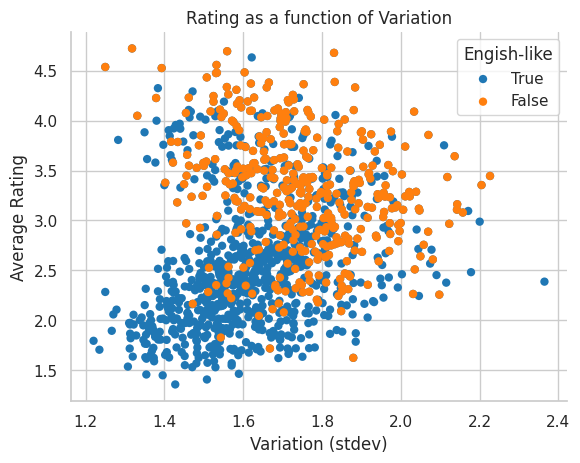

In [141]:
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=data,  x='standard dev.', y='average', label='True',
                edgecolor="none")
sns.scatterplot(data=df_unique_chars,  x='standard dev.', y='average', label='False',
                edgecolor="none")

# Finalize the ax1
ax.set_ylabel("Average Rating")
ax.set_xlabel("Variation (stdev)")
ax.set_title("Rating as a function of Variation")
ax.legend(title='Engish-like')
sns.despine()
fig.savefig("images/avg_stdev_scatter_not_eng-like")

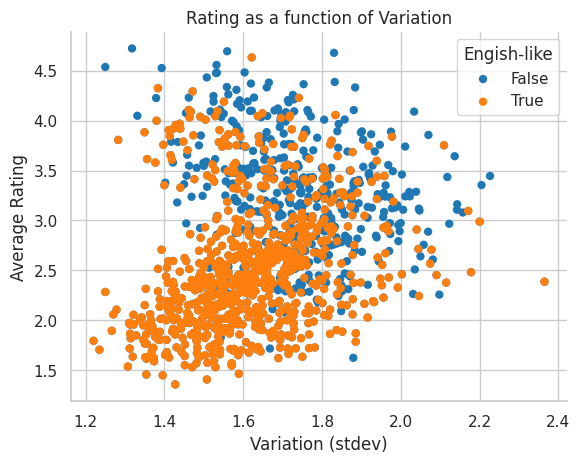

In [142]:
eng_like_chars = data[~data['codepoint'].isin(df_unique_chars['codepoint'])]
# Set up the matplotlib figure
fig, ax= plt.subplots()

# Draw a the base scatterplot
sns.scatterplot(data=data,  x='standard dev.', y='average', label='False',
                edgecolor="none")
sns.scatterplot(data=eng_like_chars,  x='standard dev.', y='average', label='True',
                edgecolor="none")

# Finalize the ax1
ax.set_ylabel("Average Rating")
ax.set_xlabel("Variation (stdev)")
ax.set_title("Rating as a function of Variation")
ax.legend(title='Engish-like')
sns.despine()
fig.savefig("images/avg_stdev_scatter_eng-like")

In [143]:
results = pg.ttest(df_unique_chars['average'], eng_like_chars['average'])
print("\nPingouin Paired T-Test Results For english-like characters vs non-english-like characters:")
print(results)


Pingouin Paired T-Test Results For english-like characters vs non-english-like characters:
                T         dof alternative         p-val         CI95%  \
T-test  20.312001  828.147925   two-sided  9.611041e-75  [0.69, 0.83]   

         cohen-d      BF10 power  
T-test  1.234089  1.17e+75   NaN  


In [144]:
df_kde_eng_like = data.copy()
df_kde_eng_like['eng_like'] = df_kde_eng_like['codepoint'].isin(eng_like_chars['codepoint'])

## Colors are inverted for readability

The dark color (english-unlike) is on the bottom beacuse it is less commons and has higher contrast with the background.

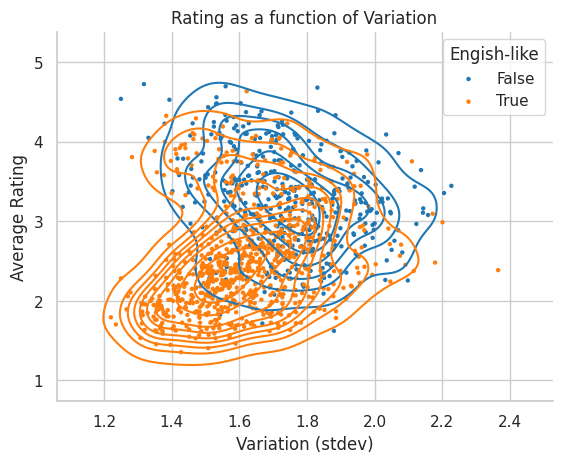

In [145]:
fig, ax= plt.subplots()

sns.scatterplot(data=df_unique_chars,  x='standard dev.', y='average', label='False', s=10,
                 edgecolor="none")
sns.scatterplot(data=eng_like_chars,  x='standard dev.', y='average', label='True', s=10,
                 edgecolor="none")
sns.kdeplot(
    data=df_kde_eng_like, x="standard dev.", y="average", hue="eng_like", color=['orange','blue']
)
ax.set_ylabel("Average Rating")
ax.set_xlabel("Variation (stdev)")
ax.set_title("Rating as a function of Variation")
ax.legend(title='Engish-like')
sns.despine()
fig.savefig("images/avg_stdev_kde_eng-like")

In [146]:
df_kde_eng = data.copy()
df_kde_eng['eng'] = df_kde_eng['codepoint'].isin(letters_df['codepoint'])

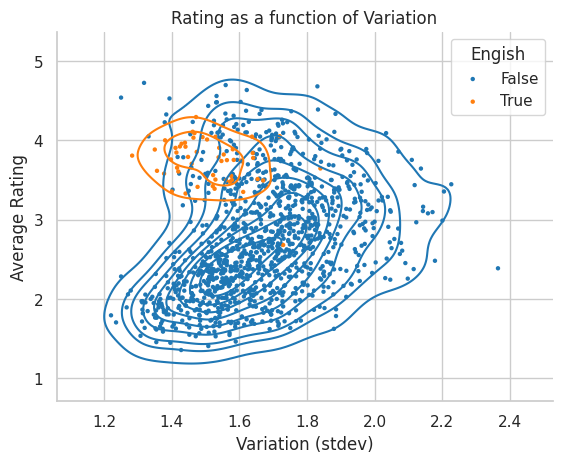

In [147]:
fig, ax= plt.subplots()

sns.scatterplot(data=special_char_df,  x='standard dev.', y='average', label='False', s=10,
                 edgecolor="none")
sns.scatterplot(data=letters_df,  x='standard dev.', y='average', label='True', s=10,
                 edgecolor="none")
sns.kdeplot(
    data=df_kde_eng, x="standard dev.", y="average", hue="eng", color=['orange','blue']
)
ax.set_ylabel("Average Rating")
ax.set_xlabel("Variation (stdev)")
ax.set_title("Rating as a function of Variation")
ax.legend(title='Engish')
sns.despine()
fig.savefig("images/avg_stdev_kde_eng")

## Plotting english-like-unlike as tier

In [163]:
eng_like_chars['eng-like'] = True
df_unique_chars['eng-like'] = False

df_both_labeled = pd.concat([eng_like_chars, df_unique_chars])

/tmp/ipykernel_19213/1903431418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_like_chars['eng-like'] = True
/tmp/ipykernel_19213/1903431418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_chars['eng-like'] = False


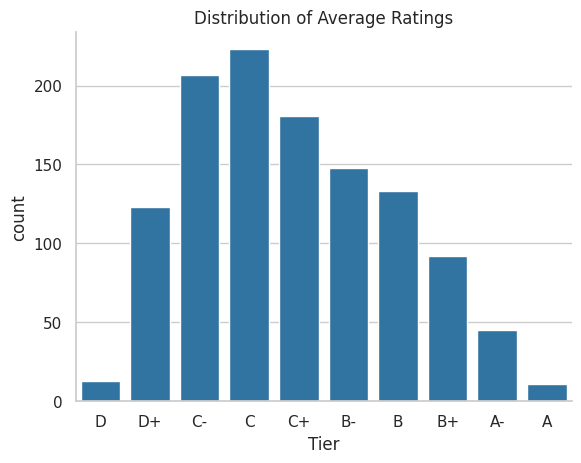

In [154]:
fig, ax = plt.subplots()
sns.countplot(data=df_both_labeled, x='tier')

ax.xaxis.set_inverted(True)
ax.set_xlabel("Tier")
ax.set_title("Distribution of Average Ratings")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/tier_dist_freq_plot")

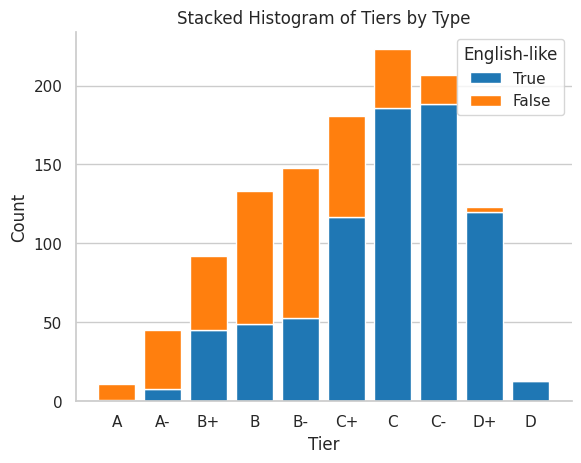

In [168]:
eng_like = [True, False]
tiers = df_both_labeled['tier'].unique()
tier_counts = {type: df_both_labeled[df_both_labeled['eng-like'] == type]['tier'].value_counts() for type in eng_like}

# Align counts for all tiers
aligned_counts = {type: [tier_counts[type].get(tier, 0) for tier in tiers] for type in eng_like}

# Plot stacked bars
fig, ax = plt.subplots()
bottom = np.zeros(len(tiers))

for type, counts in aligned_counts.items():
    ax.bar(tiers, counts, label=type, bottom=bottom)
    bottom += counts

# Finalize the plot
ax.set_xlabel("Tier")
ax.set_ylabel("Count")
ax.set_title("Stacked Histogram of Tiers by Type")
ax.legend(title="English-like")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/stacked_histogram_tiers_by_type")

In [ ]:
# Prepare data for dodged bar chart
df_both_labeled['tier'] = pd.Categorical(df_both_labeled['tier'], categories=tiers, ordered=True)

# Plot dodged bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df_both_labeled, x='tier', hue='eng-like', ax=ax)

# Finalize the plot
ax.set_xlabel("Tier")
ax.set_ylabel("Count")
ax.set_title("Dodged Bar Chart of Tiers by Type")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/dodged_bar_chart_tiers_by_type")

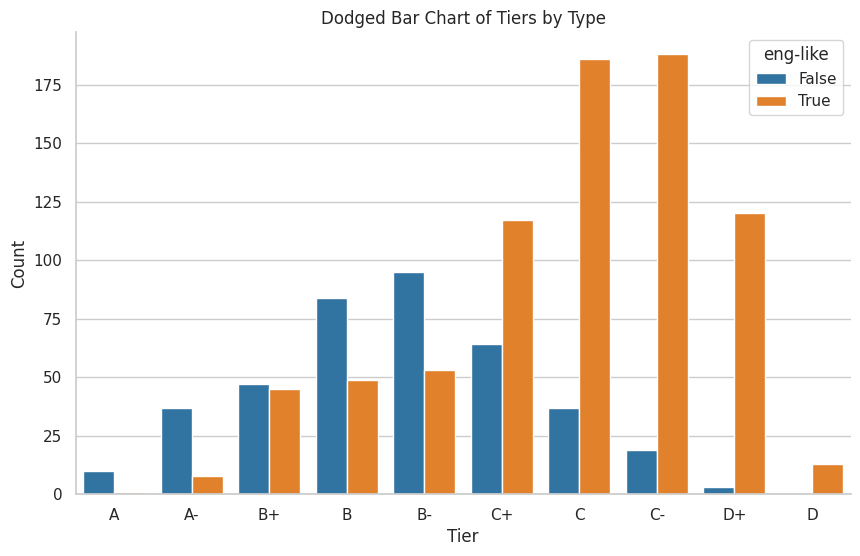

In [ ]:
df_both_labeled['tier'] = pd.Categorical(df_both_labeled['tier'], categories=tiers, ordered=True)

# Plot dodged bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df_both_labeled, x='tier', hue='eng-like', ax=ax)

# Finalize the plot
ax.set_xlabel("Tier")
ax.set_ylabel("Count")
ax.set_title("Bimodal distribution of Tiers by Type")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/dodged_bar_chart_tiers_by_type")